# Numerical simulation

In this notebook, we'll go over some simple example use-cases of SBMLtoODEjax to load SBML files from the [BioModels](https://www.ebi.ac.uk/biomodels/) website, convert them to jax modules, and run the simulation (with the provided initial conditions).

## Imports

In [1]:
import jax
jax.config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
from sbmltoodejax.utils import load_biomodel

## BioMD 10

See https://www.ebi.ac.uk/biomodels/BIOMD0000000010#Curation

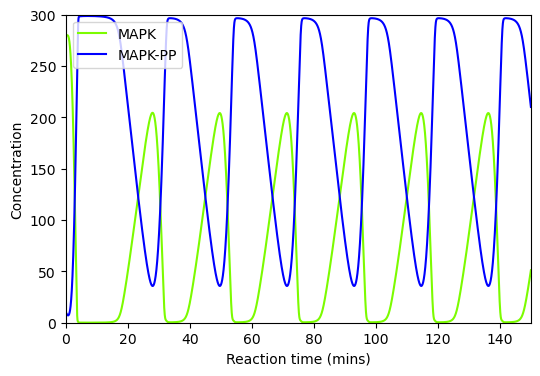

In [2]:
# load and simulate model 
model, _, _, _ = load_biomodel(10)
n_secs = 150*60
n_steps = int(n_secs / model.deltaT)
ys, ws, ts = model(n_steps)

# plot time course simulation as in original paper
y_indexes = model.modelstepfunc.y_indexes
plt.figure(figsize=(6, 4))
plt.plot(ts/60, ys[y_indexes["MAPK"]], color="lawngreen", label="MAPK")
plt.plot(ts/60, ys[y_indexes["MAPK_PP"]], color="blue", label="MAPK-PP")
plt.xlim([0,150])
plt.ylim([0,300])
plt.xlabel("Reaction time (mins)")
plt.ylabel("Concentration")
plt.legend()
plt.show()

## BioMD 37

See https://www.ebi.ac.uk/biomodels/BIOMD0000000037#Curation

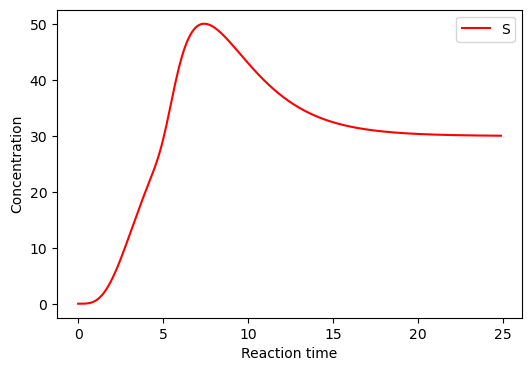

In [3]:
# load and simulate model 
model, _, _, _ = load_biomodel(37)
n_secs = 25
n_steps = int(n_secs / model.deltaT)
ys, ws, ts = model(n_steps)

# plot time course simulation as in original paper
y_indexes = model.modelstepfunc.y_indexes
plt.figure(figsize=(6, 4))
plt.plot(ts, ys[y_indexes["S"]], color="red", label="S")
plt.xlabel("Reaction time")
plt.ylabel("Concentration")
plt.legend()
plt.show()

## BioMD 50

See https://www.ebi.ac.uk/biomodels/BIOMD0000000050# load and simulate model 

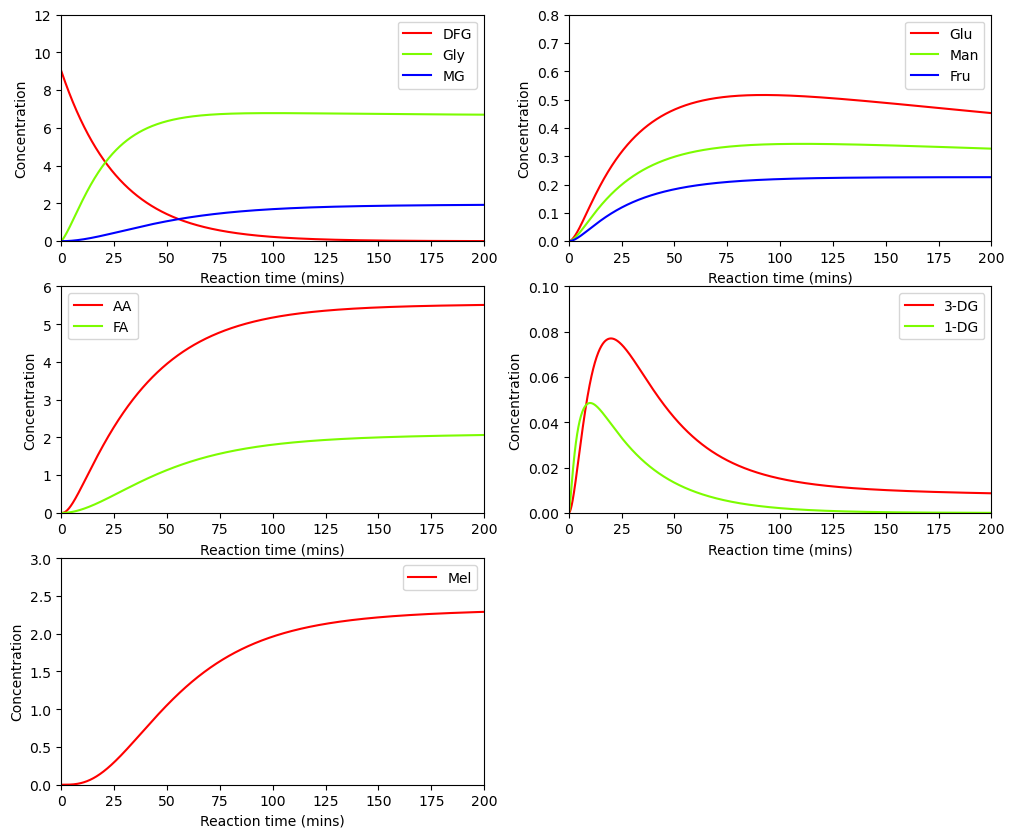

In [4]:
# load and simulate model 
model, _, _, _ = load_biomodel(50)
n_secs = 200
n_steps = int(n_secs / model.deltaT)
ys, ws, ts = model(n_steps)

# plot time course simulation as in original paper
y_indexes = model.modelstepfunc.y_indexes
fig, ax = plt.subplots(3, 2, figsize=(12, 10))

ax[0,0].plot(ts, ys[y_indexes["DFG"]], color="red", label="DFG")
ax[0,0].plot(ts, ys[y_indexes["Gly"]], color="lawngreen", label="Gly")
ax[0,0].plot(ts, ys[y_indexes["MG"]], color="blue", label="MG")
ax[0,0].set_ylim([0,12])

ax[0,1].plot(ts, ys[y_indexes["Glu"]], color="red", label="Glu")
ax[0,1].plot(ts, ys[y_indexes["Man"]], color="lawngreen", label="Man")
ax[0,1].plot(ts, ys[y_indexes["Fru"]], color="blue", label="Fru")
ax[0,1].set_ylim([0,.8])

ax[1,0].plot(ts, ys[y_indexes["AA"]], color="red", label="AA")
ax[1,0].plot(ts, ys[y_indexes["FA"]], color="lawngreen", label="FA")
ax[1,0].set_ylim([0,6])

ax[1,1].plot(ts, ys[y_indexes["_3DG"]], color="red", label="3-DG")
ax[1,1].plot(ts, ys[y_indexes["_1DG"]], color="lawngreen", label="1-DG")
ax[1,1].set_ylim([0,.1])

ax[2,0].plot(ts, ys[y_indexes["Mel"]], color="red", label="Mel")
ax[2,0].set_ylim([0,3])

for i in range(3):
    for j in range(2):
        if (i, j) != (2, 1):
            ax[i,j].set_xlim([0,200])
            ax[i,j].set_xlabel("Reaction time (mins)")
            ax[i,j].set_ylabel("Concentration")
            ax[i,j].legend()
        else:
            ax[i,j].axis("off")
plt.show()

## BioMD 52

See https://www.ebi.ac.uk/biomodels/BIOMD0000000052#Curation

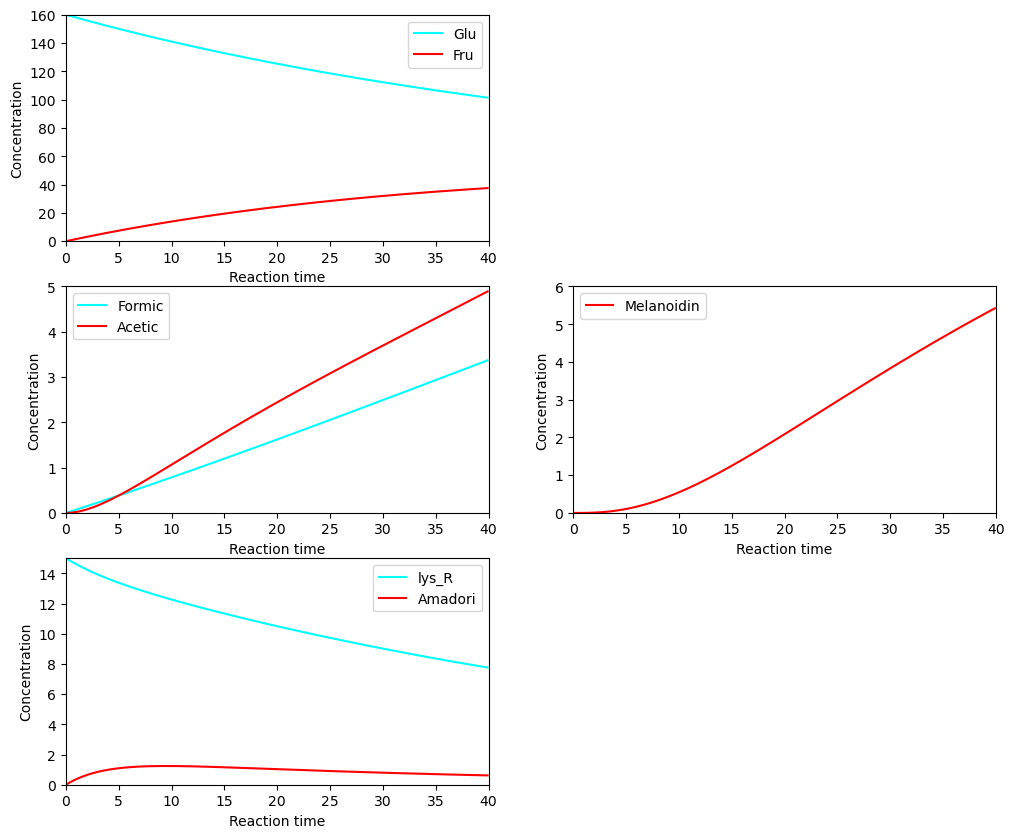

In [5]:
# load and simulate model 
model, _, _, _ = load_biomodel(52)
n_secs = 40
n_steps = int(n_secs / model.deltaT)
ys, ws, ts = model(n_steps)

# plot time course simulation as in original paper
y_indexes = model.modelstepfunc.y_indexes
fig, ax = plt.subplots(3, 2, figsize=(12, 10))

ax[0,0].plot(ts, ys[y_indexes["Glu"]], color="cyan", label="Glu")
ax[0,0].plot(ts, ys[y_indexes["Fru"]], color="red", label="Fru")
ax[0,0].set_ylim([0, 160])

ax[1,0].plot(ts, ys[y_indexes["Formic_acid"]], color="cyan", label="Formic")
ax[1,0].plot(ts, ys[y_indexes["Acetic_acid"]], color="red", label="Acetic")
ax[1,0].set_ylim([0, 5])

ax[2,0].plot(ts, ys[y_indexes["lys_R"]], color="cyan", label="lys_R")
ax[2,0].plot(ts, ys[y_indexes["Amadori"]], color="red", label="Amadori")
ax[2,0].set_ylim([0, 15])

ax[1,1].plot(ts, ys[y_indexes["Melanoidin"]], color="red", label="Melanoidin")
ax[1,1].set_ylim([0, 6])

for i in range(3):
    for j in range(2):
        if (i, j) not in [(0,1), (2, 1)]:
            ax[i,j].set_xlim([0,40])
            ax[i,j].set_xlabel("Reaction time")
            ax[i,j].set_ylabel("Concentration")
            ax[i,j].legend()
        else:
            ax[i,j].axis("off")
plt.show()

## BioMD 84

See https://www.ebi.ac.uk/biomodels/BIOMD0000000084#Curation

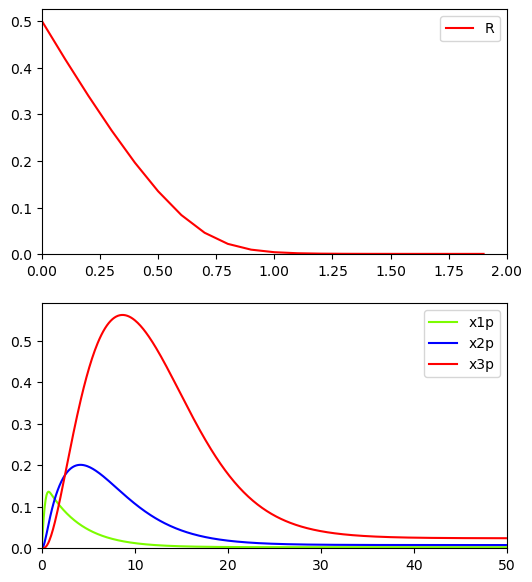

In [6]:
# load and simulate model 
model, _, _, _ = load_biomodel(84)
n_secs = 50
n_steps = int(n_secs / model.deltaT)
ys, ws, ts = model(n_steps)

# plot time course simulation as in original paper
y_indexes = model.modelstepfunc.y_indexes
fig, ax = plt.subplots(2, 1, figsize=(6, 7))
ax[0].plot(
    ts[: int(2 / model.deltaT)],
    ys[y_indexes["R"], : int(2 / model.deltaT)],
    color="red",
    label="R",
)
ax[0].legend()
ax[0].set_xlim([0.,2])
ax[0].set_ylim(bottom=0)

ax[1].plot(ts, ys[y_indexes["x1p"]], color="lawngreen", label="x1p")
ax[1].plot(ts, ys[y_indexes["x2p"]], color="blue", label="x2p")
ax[1].plot(ts, ys[y_indexes["x3p"]], color="red", label="x3p")
ax[1].legend()
ax[1].set_xlim([0.,50])
ax[1].set_ylim(bottom=0)

plt.show()

## BioMD 167

See https://www.ebi.ac.uk/biomodels/BIOMD0000000167#Curation

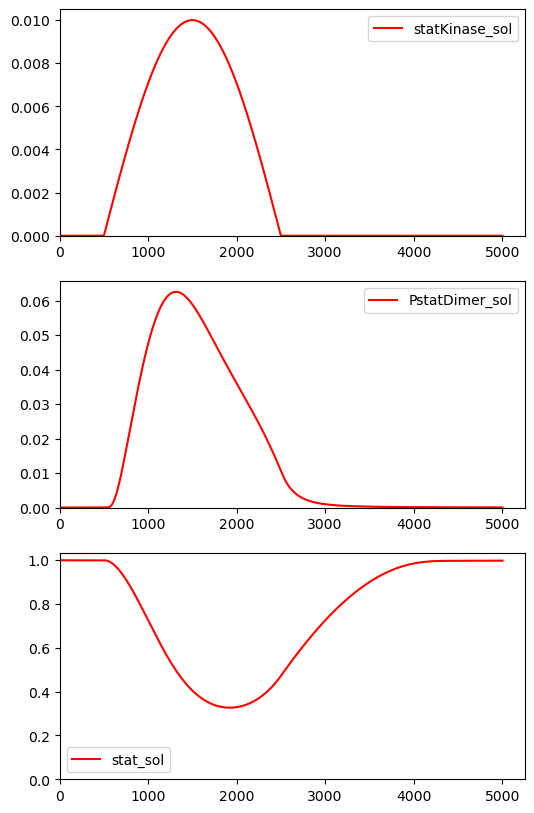

In [7]:
# load and simulate model 
model, _, _, _ = load_biomodel(167)
n_secs = 5000
n_steps = int(n_secs / model.deltaT)
ys, ws, ts = model(n_steps)

# plot time course simulation as in original paper
w_indexes = model.modelstepfunc.w_indexes
y_indexes = model.modelstepfunc.y_indexes
fig, ax = plt.subplots(3, 1, figsize=(6, 10))

ax[0].plot(ts, ws[w_indexes["statKinase_sol"]]/14.625, color="red", label="statKinase_sol")
ax[0].legend()

ax[1].plot(ts, ys[y_indexes["PstatDimer_sol"]]/14.625, color="red", label="PstatDimer_sol")
ax[1].legend()

ax[2].plot(ts, ys[y_indexes["stat_sol"]]/14.625, color="red", label="stat_sol")
ax[2].legend()

for i in range(3):
    ax[i].set_xlim(left=0)
    ax[i].set_ylim(bottom=0)

plt.show()

## BioMD 197

See https://www.ebi.ac.uk/biomodels/BIOMD0000000197#Curation

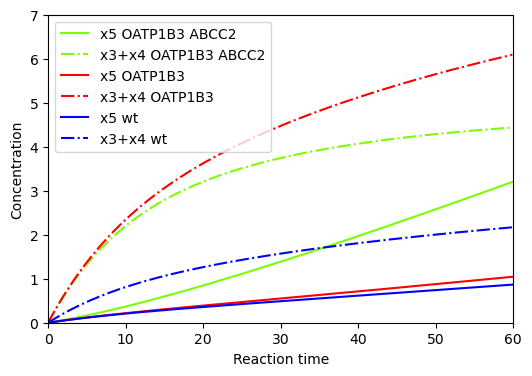

In [8]:
# load and simulate model 
model, _, _, c = load_biomodel(197)
n_secs = 60
n_steps = int(n_secs / model.deltaT)

# sim default
ys, _, ts = model(n_steps)

# sim 1
c_OATP1B3 = c.at[1].set(0.)
ys_OATP1B3, _, ts = model(n_steps, c=c_OATP1B3)


# sim 2
c_wt = c.at[:2].set(0.)
ys_wt, _, ts = model(n_steps, c=c_wt)

# plot time course simulation as in original paper
y_indexes = model.modelstepfunc.y_indexes
plt.figure(figsize=(6, 4))

plt.plot(ts, ys[y_indexes["x5"]], color="lawngreen", label="x5 OATP1B3 ABCC2")
plt.plot(ts, ys[y_indexes["x3"]]+ys[y_indexes["x4"]], color="lawngreen", linestyle="-.", label="x3+x4 OATP1B3 ABCC2")

plt.plot(ts, ys_OATP1B3[y_indexes["x5"]], color="red", label="x5 OATP1B3")
plt.plot(ts, ys_OATP1B3[y_indexes["x3"]]+ys_OATP1B3[y_indexes["x4"]], color="red", linestyle="-.", label="x3+x4 OATP1B3")

plt.plot(ts, ys_wt[y_indexes["x5"]], color="blue", label="x5 wt")
plt.plot(ts, ys_wt[y_indexes["x3"]]+ys_wt[y_indexes["x4"]], color="blue", linestyle="-.", label="x3+x4 wt")

plt.xlabel("Reaction time")
plt.ylabel("Concentration")
plt.xlim([0,60])
plt.ylim([0,7])
plt.legend()
plt.show()

## BioMD 240

See https://www.ebi.ac.uk/biomodels/BIOMD0000000240#Curation

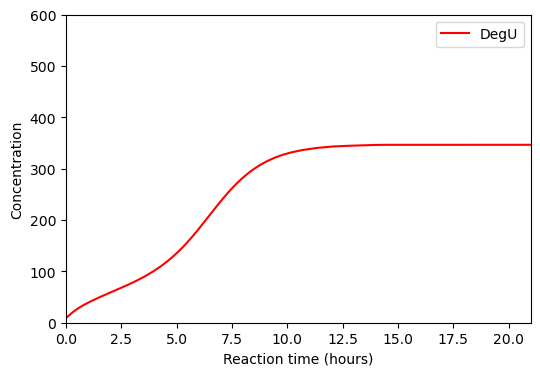

In [9]:
# load and simulate model 
model, _, _, c = load_biomodel(240)
n_secs = 21*3600
n_steps = int(n_secs / model.deltaT)
ys, ws, ts = model(n_steps)

# plot time course simulation as in original paper
w_indexes = model.modelstepfunc.w_indexes
plt.figure(figsize=(6, 4))
plt.plot(ts/3600, ws[w_indexes["DegU_Total"]], color="red", label="DegU")
plt.xlabel("Reaction time (hours)")
plt.ylabel("Concentration")
plt.xlim([0,21])
plt.ylim([0,600])
plt.legend()
plt.show()

## BioMD 271

See https://www.ebi.ac.uk/biomodels/BIOMD0000000271#Curation

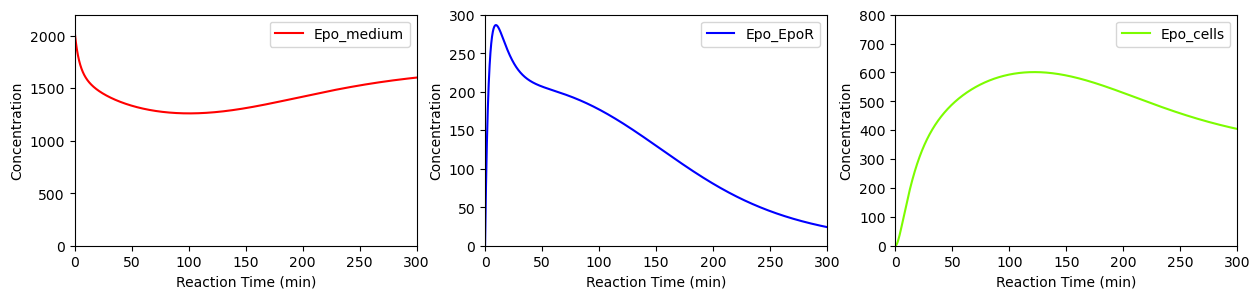

In [10]:
# load and simulate model 
model, _, _, c = load_biomodel(271)
w_indexes = model.modelstepfunc.w_indexes
y_indexes = model.modelstepfunc.y_indexes
n_secs = 300
n_steps = int(n_secs / model.deltaT)

# simulation
ys, ws, ts = model(n_steps, c=c)

# plot time course simulation as in original paper
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

ax[0].plot(ts, ws[w_indexes["Epo_medium"]], color="red", label="Epo_medium")
ax[0].set_ylim([0,2200])

ax[1].plot(ts, ys[y_indexes["Epo_EpoR"]], color="blue", label="Epo_EpoR")
ax[1].set_ylim([0,300])

ax[2].plot(ts, ws[w_indexes["Epo_cells"]], color="lawngreen", label="Epo_cells")
ax[2].set_ylim([0,800])

for i in range(3):
    ax[i].set_xlim([0,300])
    ax[i].legend()
    ax[i].set_ylabel("Concentration")
    ax[i].set_xlabel("Reaction Time (min)")

plt.show()

## BioMD 641

See https://www.ebi.ac.uk/biomodels/BIOMD0000000641#Curation

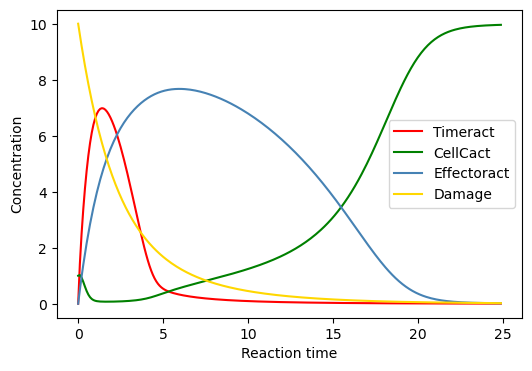

In [11]:
# load and simulate model 
model, _, _, c = load_biomodel(641)
n_secs = 25
n_steps = int(n_secs / model.deltaT)
ys, ws, ts = model(n_steps)

# plot time course simulation as in original paper
y_indexes = model.modelstepfunc.y_indexes
w_indexes = model.modelstepfunc.w_indexes
plt.figure(figsize=(6, 4))
plt.plot(ts, ys[y_indexes["Timeract"]], color="red", label="Timeract")
plt.plot(ts, ys[y_indexes["CellCact"]], color="green", label="CellCact")
plt.plot(ts, ys[y_indexes["Effectoract"]], color="steelblue", label="Effectoract")
plt.plot(ts, ws[w_indexes["Damage"]], color="gold", label="Damage")
plt.xlabel("Reaction time")
plt.ylabel("Concentration")
plt.legend()
plt.show()

## ⚠️ Error Cases

Note that SBMLtoODEjax does not (yet) handles the numerical simulation of all models present on the BioModels website, or more generally it does not handle all possible SBML files. 
We detail below the error types we obtain when trying to simulate the list of currently-hosted curated models (1048 models in total):

<img src="../_static/error_cases.png" alt="conversion_simulation_success_rate" style="width: 600px;"/>